# AIAP 22 Technical Assessment - Exploratory Data Analysis for Phishing Dataset 


## Table of Contents<a id='0'></a>

### [1. Introduction](#1)

- Problem Statement
- Data Description

### [2. Data Acquisition and Loading](#2)

- Notebook Setup
- Load Data


### [3. Data Cleaning and Processing](#3)

- Rename Columns and Convert Types
- Drop Duplicates
- Handling Unusual Values and Ranges
- Handling Null Values

### [4. Data Analysis and Visualisation](#4)
- Analyses of Impact of Categorical Variables on Activity Level
- Analyses of Impact of Numerical Variables on Activity Level

### [5. Conclusions](#5)
- Insights
- Next Steps
---

## 1. Introduction<a id='1'></a>
[Return to Table of Contents](#0)

### Problem Statement
 



### Data Description

---

## 2. Data Acquisition and Loading<a id='2'></a>
[Return to Table of Contents](#0)

### 2a. Notebook Setup

In [76]:
# Load necessary packages for data ingestion, cleaning EDA 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import normaltest, chi2_contingency, ttest_ind, f_oneway
from sqlalchemy import create_engine, MetaData, Table, inspect
import requests
import sqlite3
from pathlib import Path
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Set Pandas options

%matplotlib inline
plt.rcParams['figure.figsize'] = [25,10]
plt.rcParams['font.size'] = 24
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 120)

### 2b. Load Data

In [ ]:

DATA_URL = "https://techassessment.blob.core.windows.net/aiap22-assessment-data/phishing.db"
DATA_DIR = Path("data")
DB_PATH = DATA_DIR / "phishing.db"

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_database(force_refresh=False):
    """Download the phishing SQLite DB unless a cached copy exists (or refresh requested)."""
    if DB_PATH.exists() and not force_refresh:
        print(f"Using cached database at {DB_PATH.resolve()}")
        return DB_PATH

    print("Downloading phishing.db ...")
    response = requests.get(DATA_URL, timeout=30)
    response.raise_for_status()
    DB_PATH.write_bytes(response.content)
    print(f"Saved database to {DB_PATH.resolve()}")
    return DB_PATH

db_path = download_database()
db_path


Using cached database at C:\Users\epist\OneDrive\Desktop\aiap-22-project\data\phishing.db


WindowsPath('data/phishing.db')

In [30]:
# Load dataset using Sqlalchemy

engine = create_engine('sqlite:///data/phishing.db')
conn = engine.connect()

# Reflect data
metadata = MetaData()
metadata.reflect(bind=engine)

# Check what tables exist
insp = inspect(engine)
tables = insp.get_table_names()
print('\033[1m'+ "Tables in DB: " + '\033[0m', tables) 


Tables in DB:  ['phishing_data']


In [ ]:
# Convert table(s) in db to pandas df:
df = pd.read_sql_table('phishing_data', con=engine)

### 2c. Basic Inspection

In [ ]:
# Show first 5 rows of the dataframe for visual inspection

df.head()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.00,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.00,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.00,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.00,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


In [25]:
# Print index, shape, data types

print('\033[1m'+ "Index: " + '\033[0m', df.index)
print('\033[1m' + "Number of rows: " + '\033[0m', df.shape[0])
print('\033[1m' + "Number of columns: " + '\033[0m', df.shape[1])
print('\033[1m' + "Data Types:" + '\033[0m\n' + str(df.dtypes))

Index:  RangeIndex(start=0, stop=10500, step=1)
Number of rows:  10500
Number of columns:  16
Data Types:
Unnamed: 0             int64
LineOfCode           float64
LargestLineLength      int64
NoOfURLRedirect        int64
NoOfSelfRedirect       int64
NoOfPopup              int64
NoOfiFrame             int64
NoOfImage              int64
NoOfSelfRef            int64
NoOfExternalRef        int64
Robots                 int64
IsResponsive           int64
Industry              object
HostingProvider       object
DomainAgeMonths        int64
label                  int64
dtype: object


In [26]:
# Check for null values

print('\033[1m' + "Total number of null values per column: "  + '\033[0m\n' + str(df.isnull().sum()))

# Check for number of unique values per column:

print('\033[1m' + "Total number of unique values per column: "  + '\033[0m\n' + str(df.nunique()))

Total number of null values per column: 
Unnamed: 0              0
LineOfCode           2355
LargestLineLength       0
NoOfURLRedirect         0
NoOfSelfRedirect        0
NoOfPopup               0
NoOfiFrame              0
NoOfImage               0
NoOfSelfRef             0
NoOfExternalRef         0
Robots                  0
IsResponsive            0
Industry                0
HostingProvider         0
DomainAgeMonths         0
label                   0
dtype: int64
Total number of unique values per column: 
Unnamed: 0           10500
LineOfCode            2875
LargestLineLength     4027
NoOfURLRedirect          2
NoOfSelfRedirect         2
NoOfPopup               26
NoOfiFrame              48
NoOfImage              308
NoOfSelfRef            533
NoOfExternalRef        463
Robots                   2
IsResponsive             2
Industry                11
HostingProvider         13
DomainAgeMonths        121
label                    2
dtype: int64


In [34]:
# List unique values for each categorical column (excluding one-hotted): 

for col in df.columns:
    if df[col].dtype == 'object':
        print('\033[1m' + "Unique Values of " + col + ": "  + '\033[0m\n' + str(df[col].unique()))


Unique Values of Industry: 
['Fashion' 'Education' 'Unknown' 'Manufacturing' 'eCommerce ' 'Non-profit'
 'Food' 'Government' 'eCommerce' 'Banking' 'Healthcare']
Unique Values of HostingProvider: 
['DreamHost' 'AWS' 'Google Cloud' 'GoDaddy' 'Freehostia' 'Bluehost'
 'Unknown Provider' 'Hostinger' 'Namecheap' 'InfinityFree' '000webhost'
 'Azure' 'HostGator']


In [35]:
# List summary statistics for each numerical column:

df.describe()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label
count,10500.00,8145.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00
mean,5249.50,1376.95,11197.96,0.14,0.04,0.23,1.67,325.27,68.54,51.15,0.26,0.62,33.17,0.55
std,3031.23,5751.56,94168.98,0.34,0.19,5.70,5.02,30896.86,316.68,204.90,0.44,0.48,32.70,0.50
min,0.00,2.00,22.00,0.00,0.00,0.00,0.00,-35.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2624.75,88.00,180.75,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,5.00,0.00
50%,5249.50,620.00,1087.50,0.00,0.00,0.00,0.00,5.00,12.00,10.00,0.00,1.00,24.00,1.00
75%,7874.25,1452.00,8047.00,0.00,0.00,0.00,1.00,25.00,87.00,55.00,1.00,1.00,52.00,1.00
max,10499.00,418650.00,4336498.00,1.00,1.00,564.00,131.00,3166000.00,26596.00,12353.00,1.00,1.00,120.00,1.00


In [61]:
# Check for duplicate rows

df_dup = df[df.duplicated()]
df_dup.head()
print('\033[1m' + 'Total number of duplicated rows: ' + '\033[0m\n'  + str(len(df_dup)))


Total number of duplicated rows: 
0


In [47]:
# Categorize columns into categorical and numerical

cat_cols = ['NoOfPopup', 'NoOfiFrame', 'Robots', 'IsResponsive', 'Industry', 'HostingProvider', 'label']
num_cols = ['LineOfCode', 'LargestLineLength', 'NoOfURLRedirect','NoOfSelfRedirect', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 
'NoOfSelfRef', 'NoOfExternalRef', 'DomainAgeMonths']

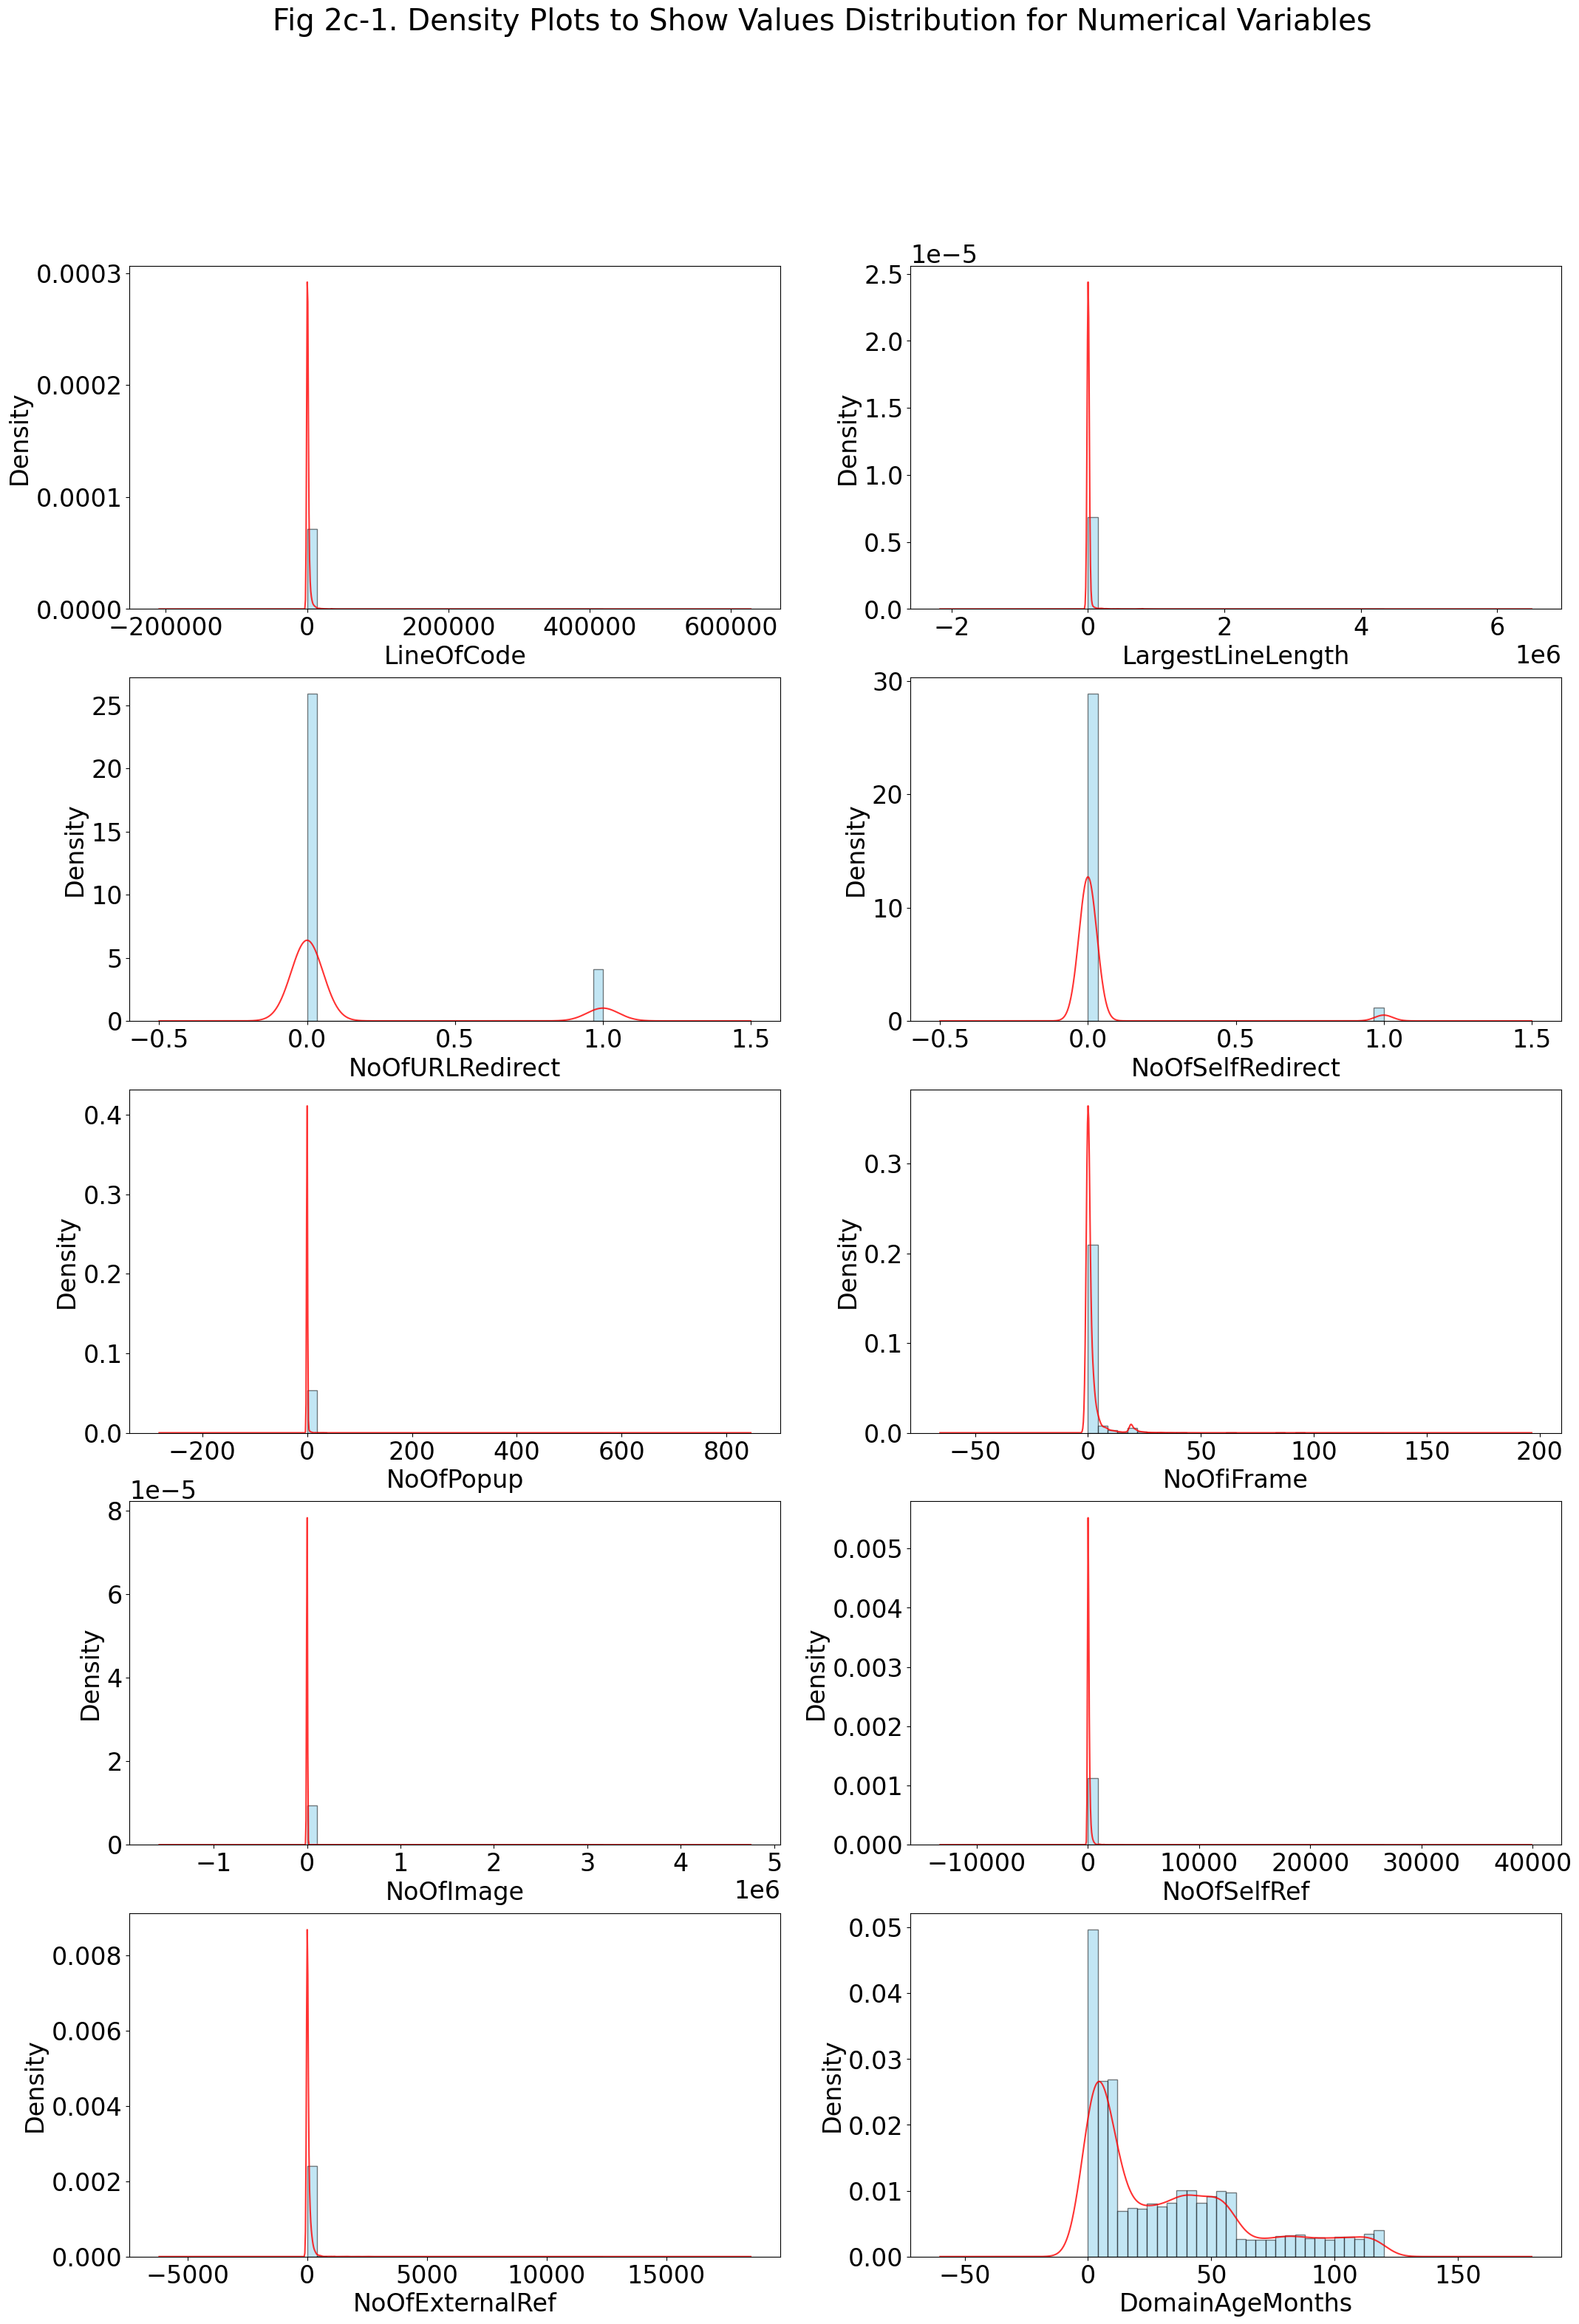

In [75]:
# Plot frequency distributions of each non-categorical continuous variable

plt.close('all') 

fig, axes = plt.subplots(5, 2, figsize=(25, 35))  # increase vertical figure size (height)
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(num_cols):
    df[col].plot(kind='hist', ax=axes[i], density=True, bins=30, alpha=0.5, color='skyblue', edgecolor='k')
    df[col].plot(kind='kde', ax=axes[i], alpha=0.8, color='red')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.suptitle("Fig 2c-1. Density Plots to Show Values Distribution for Numerical Variables")
plt.show()

Basic inspection of the above suggests the following data cleaning steps are needed for EDA:

1. **Address Null Values**. About 20% of **LineofCode** contains null values that need to be either imputed or eliminated.
2. **Address Outliers/Unusual Values**: Diagnose and address potential outlier/unusual values in **NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef**. In particular, the negative values in **NoOfImage**.

---  

## 3. Data Cleaning and Processing<a id='3'></a>
[Return to Table of Contents](#0)

### 3a. Addressing Null Values

**LineOfCode** has a significant number of null values (~20% of the dataset). Given the large proportion, there is a need to determine how to inpute suitable values. We do this by analysing if there is a pattern to the nullness of **LineOfCode** and various categorical features.

In [ ]:
# Run pairwise significance tests to determine if there are meaningful patterns in the dropped data

# Create a missingness indicator for LineOfCode
df["missing_flag"] = df["LineOfCode"].isnull().astype(int)

print('\033[1m\n' + "Missingness Analysis for Categorical Data" + '\033[0m\n')

for j in cat_cols:
    # Cross-tabulate missingness of LineOfCode against the values of categorical column j
    contingency_table = pd.crosstab(df["missing_flag"], df[j])

    try:
        chi2, p, _, _ = chi2_contingency(contingency_table)

        if p < 0.05:
            print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
        else:
            print(f"No relationship detected between missingness in LineOfCode and '{j}' → Possibly MCAR")
    except ValueError:
        print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")

print('\033[1m\n' + "Missingness Analysis for Numeric Data" + '\033[0m\n')

for j in num_cols:
    if j != "LineOfCode":
        group0 = df[df["missing_flag"] == 0][j].dropna()
        group1 = df[df["missing_flag"] == 1][j].dropna()

        # Ensure both groups have enough data
        if len(group0) > 1 and len(group1) > 1:
            stat, p = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test
            if p < 0.05:
                print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
            else:
                print(f"No relationship detected between missingness in LineOfCode and '{j}'  → Possibly MCAR")
        
        else:
            print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")



# Drop temp column
df.drop(columns="missing_flag", inplace=True)


Missingness Analysis for Categorical Data

Missingness in LineOfCode is related to 'NoOfPopup' based on p=value of 1.2621241645089938e-05 → Not MCAR
Missingness in LineOfCode is related to 'NoOfiFrame' based on p=value of 1.1253672173424259e-59 → Not MCAR
Missingness in LineOfCode is related to 'Robots' based on p=value of 2.731032635061394e-48 → Not MCAR
Missingness in LineOfCode is related to 'IsResponsive' based on p=value of 2.325464769941828e-99 → Not MCAR
Missingness in LineOfCode is related to 'Industry' based on p=value of 4.455411372603803e-33 → Not MCAR
Missingness in LineOfCode is related to 'HostingProvider' based on p=value of 5.58165205430259e-130 → Not MCAR
Missingness in LineOfCode is related to 'label' based on p=value of 0.0 → Not MCAR

Missingness Analysis for Numeric Data

No relationship detected between missingness in LineOfCode and 'LargestLineLength'  → Possibly MCAR
No relationship detected between missingness in LineOfCode and 'NoOfURLRedirect'  → Possibly MC

### 3b. Unusual and Outlier Values

**NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef** all have values that are significantly outside the standard deviation ranges of their distributions. We need to take a closer look to determine if these values can be dropped.

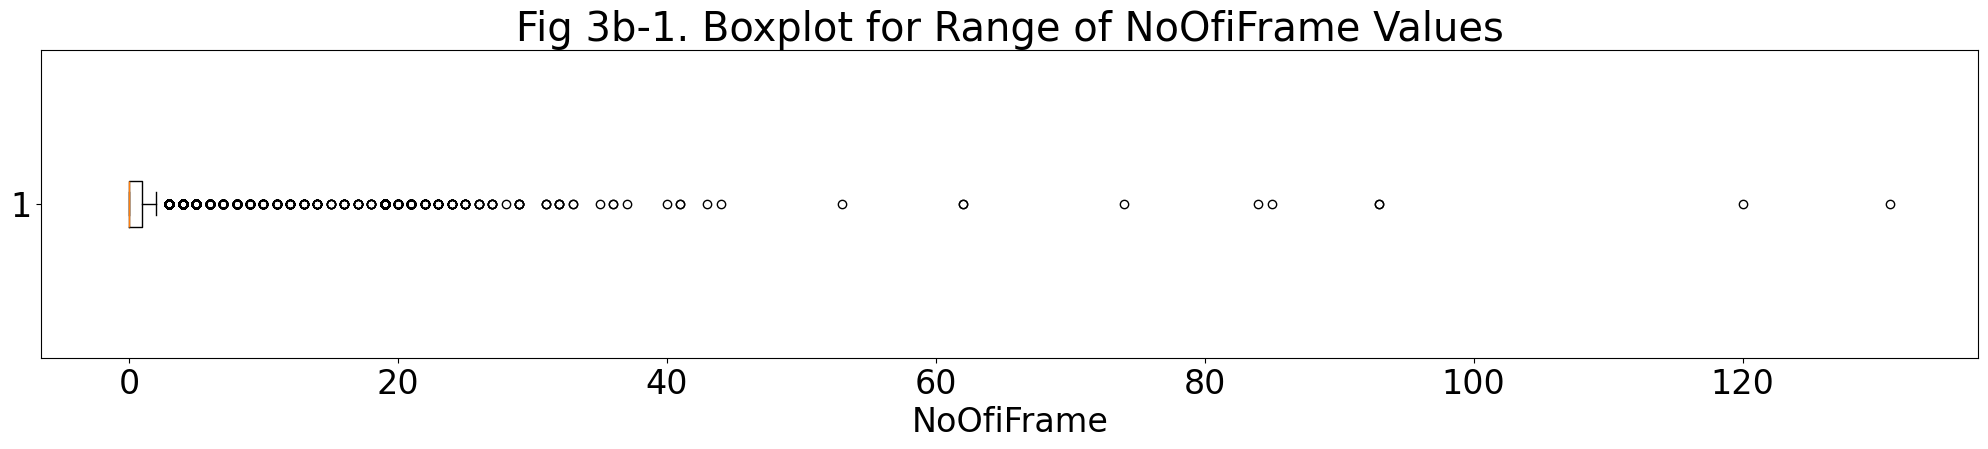

In [89]:
# Inspect range of NoOfiFrame values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfiFrame"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfiFrame Values")
plt.xlabel("NoOfiFrame")
plt.show()


**Analysis of NoOfiFrame**: the distribution clusters mainly around 0-1 iFrames per page, with a number of right-skewed outliers. Internet research suggests that sites with as many as hundreds of iFrames are possible and are indeed significantly associated with malicious sites, so we will take the presence of such outliers as useful signals for the model.

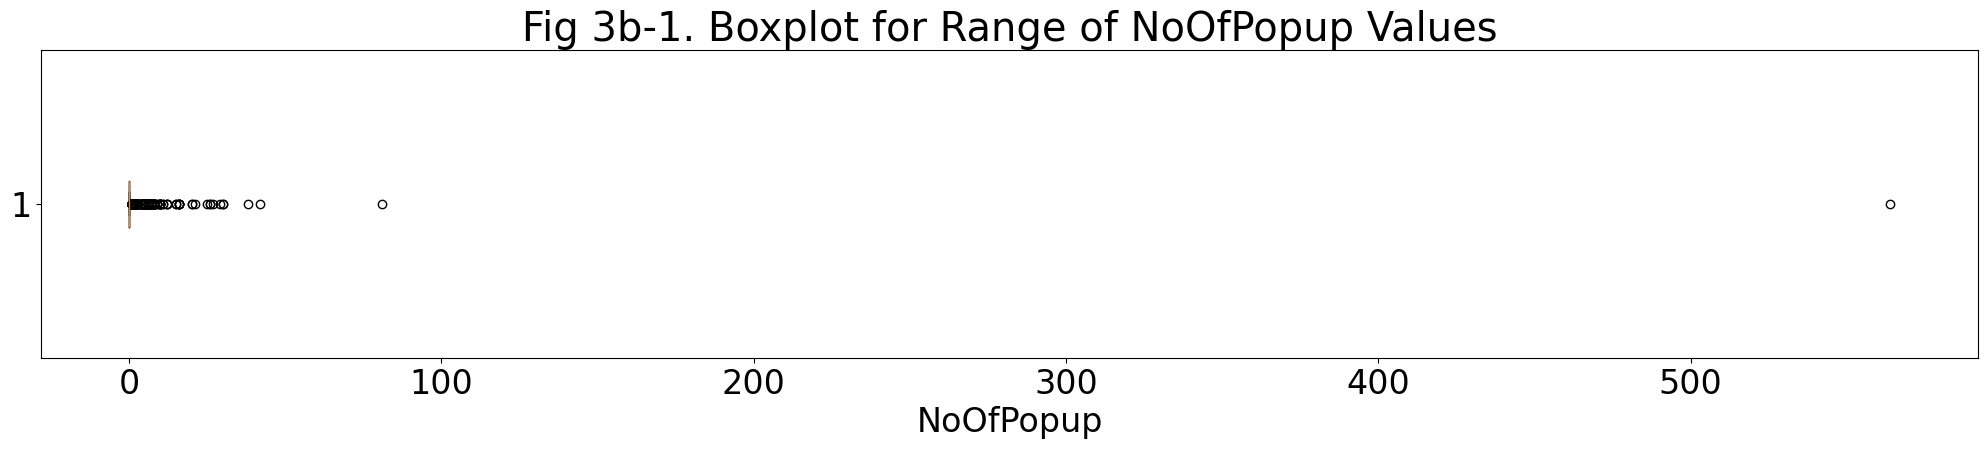

In [94]:
# Inspect range of NoOfPopup values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfPopup"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfPopup Values")
plt.xlabel("NoOfPopup")
plt.show()

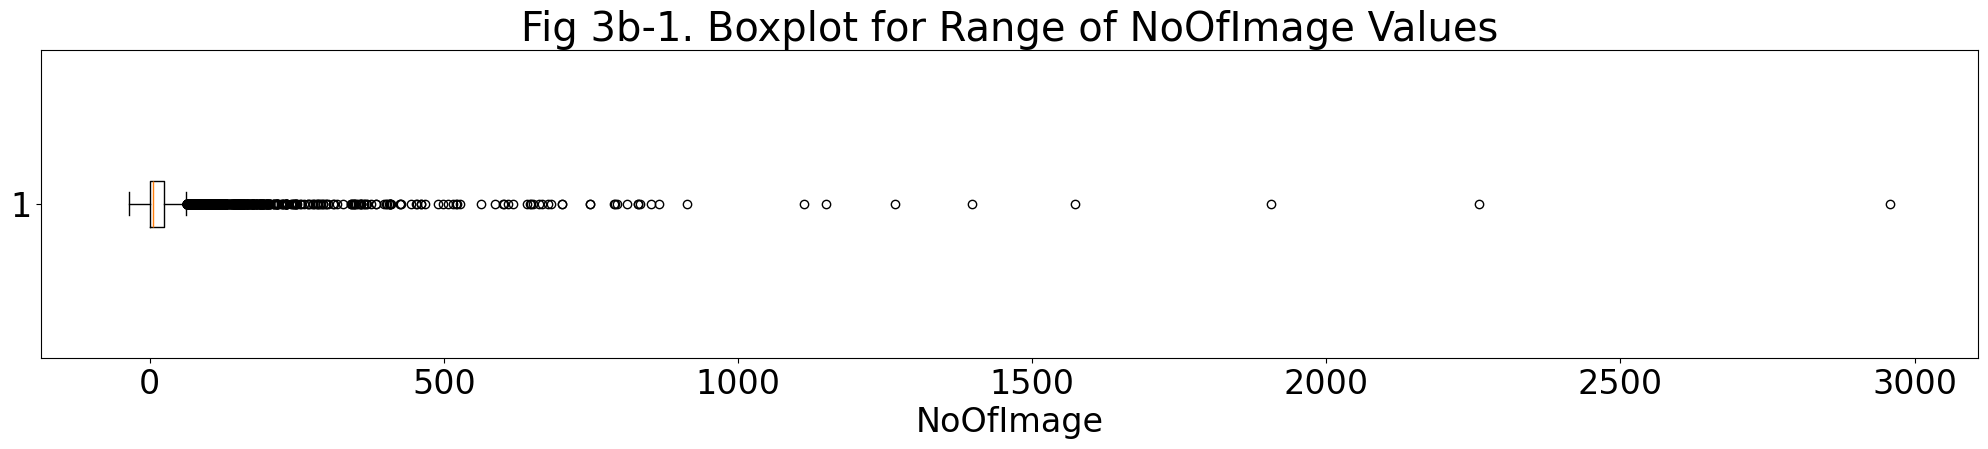

In [ ]:
# Inspect range of NoOfImage values

plt.figure(figsize=(25, 4))
plt.boxplot(df[df["NoOfImage"] < 1000000]["NoOfImage"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfImage Values")
plt.xlabel("NoOfImage")
plt.show()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
1,1,769.00,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.00,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.00,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.00,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1
5,5,247.00,4462,0,0,0,0,3,4,4,0,1,Manufacturing,AWS,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10493,10493,11.00,99,0,0,0,0,0,0,0,0,0,Education,DreamHost,0,1
10494,10494,118.00,2143,0,0,0,0,0,0,4,0,0,Non-profit,InfinityFree,4,1
10496,10496,20.00,207,1,1,0,0,0,0,0,0,0,Unknown,000webhost,9,0
10498,10498,2.00,40,0,0,0,0,0,0,0,0,0,eCommerce,000webhost,32,1
